# Actividad - Proyecto práctico

> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
* Alumno 1: Benali, Abdelilah
* Alumno 2: Cuesta Cifuentes, Jair
* Alumno 3: González Huete, Manel
* Alumno 4: Manzanas Mogrovejo, Francisco
* Alumno 5: Pascual, Guadalupe

---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.




---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda update --all
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Preparar Colab

<font color='red'>**IMPORTANTE:**</font><br>
El entorno de Colab está preinstalado con una serie de librerías por defecto. Para trabajar en base a las especificaciones del ejercicio se necesitan intalar unas librerías que bajen de versión las existentes en Colab. Entre ellas tensorflow. El problema de realizar esta acción es que para que todas las versiones sean consideradas por el entorno hay que reiniciar la sesión, sino se mantienen dependencias y los import no funcionan. <br>
Es decir tras los "pip install" hay que hacer un **"Runtime > Restart runtime"** o si tienes Colab en español: "Entorno de Ejecución/Reiniciar sesion".<br>
En este punto se ha de tener presente que se ha reiniciado y **se han perdido las variables** que se hayan establecido, por ese motivo repetiremos el código para identificar si estamos en Colab.

In [ ]:
# Verificamos si estamos en Colab
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

#### 1.2.1. Instalar librerías necesarias

<font color='red'>**IMPORTANTE:**</font><br>
Ignorar los errores que puedan aparecer, son incompatibilidades con librerías avanzadas que no utilizamos ni necesitamos para nuestro código.

In [ ]:
import sys
import os
#Si ya tenemos lasa librerías cargadas desde requirements.txt --> false
INSTALL_LOCAL = False
#Si quremos trabajar con el entorno nativo --> false
IN_COLAB_ENV = False

if IN_COLAB:  
# =========================
#  Entorno Colab nativo con todo lo compatible.
#  Sólo recordar que se debe REINICIAR EL RUNTIME (al acabar)
# =========================  
  print("Instalando paquetes adicionales...")  
  print("="*60)
  print("IMPORTANTE: Ignorar los errores que aparecen:")
  print("   Son incompatibilidades que aparecen con librería avanzadas")
  print("   que no necesitamos ni vamos a utilizar")  
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git@1.2.2
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.12.1 --quiet
  print("\n" + "="*60)
  print("INSTALACIÓN COMPLETADA")
  print("="*60)
  print("IMPORTANTE: Debes REINICIAR EL RUNTIME ahora:")
  print("1. Ve a Runtime > Restart runtime")
  print("2. Después ejecuta las importaciones")
  print("="*60)  
  INSTALL_LOCAL = False
  IN_COLAB_ENV = False

if IN_COLAB_ENV:
# =========================
#  Colab con env --> 
#    no funciona muy bien pues aunque se cree el entorno, Colab sigue
#    utilizando el suyo con sus librería y se necesita usar %%writefile
# =========================      
  # 1. Instalar virtualenv
  !pip install virtualenv --quiet

  # 3. Crear el entorno virtual llamado "miar_rl"
  !virtualenv miar_rl

  # 4. Instala paquetes DENTRO del entorno virtual con versiones exactas
  !./miar_rl/bin/pip install numpy==1.23.5 --quiet
  !./miar_rl/bin/pip install gym==0.17.3 --quiet
  !./miar_rl/bin/pip install tensorflow==2.12.1 keras==2.12.0 --quiet
  !./miar_rl/bin/pip install git+https://github.com/Kojoley/atari-py.git@1.2.2 --quiet
  !./miar_rl/bin/pip install keras-rl2==1.0.5 --quiet

  # 5. Librerías adicionales
  !./miar_rl/bin/pip install Pillow
  !./miar_rl/bin/pip install matplotlib
  !./miar_rl/bin/pip install tqdm
  INSTALL_LOCAL = False
    
if INSTALL_LOCAL:    
# =========================
#  Librería para trabajar en local, si NO se cargaron las 
#    librerías desde fichero requirements
# =========================        
  %pip install numpy==1.23.5
  %pip install gym==0.17
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0
  %pip install matplotlib==3.4.3
  %pip install tqdm
  %pip install imageio==2.15.0

---
### 1.3. Localizar entorno de trabajo: Google colab o local

**IMPORTANTE:**<br>
Recordar que antes de seguir (si hemos decidido el entorno de Colab nativo - IN_COLAB=True -) 
* Hay que hacer un <font color='red'>"Runtime > Restart runtime"</font> o si tienes Colab en español: "Entorno de Ejecución/Reiniciar sesion".

In [1]:
#Si ya tenemos lasa librerías cargadas desde requirements.txt --> false
INSTALL_LOCAL = False
#Si quremos trabajar con el entorno nativo --> false
IN_COLAB_ENV = False

# Verificamos si estamos en Colab
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

In [3]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/VIU/08_AR_MIAR/sesiones_practicas/sesion_practica_1"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.4. Montar carpeta de datos local (solo Colab)

In [4]:
# Cambiar al directorio en Google Drive que deseas usar
import os
if IN_COLAB:
  print("Estamos ejecutando en Colab")

  if IN_COLAB:
    # Montar Google Drive en el punto de montaje
    print("Colab: montando Google drive en: ", mount)

    drive.mount(mount)

    # Crear drive_root si no existe
    create_drive_root = True
    if create_drive_root:
      print("\nColab: Asegurando que ", drive_root, " existe.")
      os.makedirs(drive_root, exist_ok=True)

    # Cambiar al directorio
    print("\nColab: Cambiamos el directorio a: ", drive_root)
    %cd $drive_root
# Verificar que estamos en el directorio de trabajo correcto
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['.anaconda', '.cache', '.conda', '.condarc', '.config', '.continuum', '.dia', '.git', '.gitconfig', '.gitignore', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.Ld9VirtualBox', '.lesshst', '.matplotlib', '.viminfo', '.virtual_documents', '.vscode', '01MAIR_ACT_Video.ipynb', '01MIAR_00_Intro.ipynb', '01MIAR_01_Python101.ipynb', '01MIAR_02_Python101_DataTypes.ipynb', '01MIAR_03_Python101_Control.ipynb', '01MIAR_04_Python101_Functions.ipynb', '01MIAR_05_Python101_Files.ipynb', '01MIAR_06_Python101_OOP.ipynb', '01MIAR_07_Python101_Advanced.ipynb', '01MIAR_08_NumPy.ipynb', '01MIAR_09_Pandas.ipynb', '01MIAR_10_+Pandas.ipynb', '01MIAR_11_Visualization.ipynb', '01MIAR_12_Data_Processing.ipynb', '01MIAR_13_Generators.ipynb', '01MIAR_14_Natural_Language.ipynb', '01MIAR_15_OCR.ipynb', '01MIAR_16_Image_Analysis.ipynb', '01MIAR_ACT_Actividad_Final.ipynb', '01MIAR_ACT_Final.ipynb', '01MIAR_ACT_Group.ipynb', '01MIAR_ACT_Group_Solved.ipynb', '01MIAR_ACT_WhitePap

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [6]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc       # Para garbage collection
import random
import os
import pickle
import re       # Para expresiones regulares en carga de checkpoints
import gym      # Para el entorno de Atari
import cv2     # Para preprocesamiento de imágenes si se usa AtariProcessor
import warnings
import time
import psutil
import tracemalloc
import json
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent, AbstractDQNAgent

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.layers import Lambda, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from collections import deque
from tqdm import trange     # Necesaria para la barra de progreso en simple_train
import tensorflow.keras.backend as K

In [7]:
# Necesario para la grabación de video
try:
    import gym.wrappers
except ImportError:
    print("WARNING: gym.wrappers no está disponible. La grabación de video no funcionará.")
    gym.wrappers = None # Asegurar que no dé error si no se encuentra


In [8]:
# Configurar TensorFlow para CPU (x cores)
def optimizar_tensorflow():
    """Configura TensorFlow para rendimiento óptimo en CPU/GPU"""
    # Limpiar sesión previa
    gc.collect()

    # Optimización de GPU si está disponible
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU optimizada para crecimiento adaptativo de memoria")
        except Exception as e:
            print(f"Error al configurar GPU: {e}")

    # Optimización de CPU
    num_cpu_cores = os.cpu_count() or 8  # Fallback a 8 si no se puede detectar

    os.environ["OMP_NUM_THREADS"] = str(num_cpu_cores // 2)
    os.environ["OPENBLAS_NUM_THREADS"] = str(num_cpu_cores // 2)
    os.environ["MKL_NUM_THREADS"] = str(num_cpu_cores // 2)

    tf.config.threading.set_intra_op_parallelism_threads(num_cpu_cores // 2)
    tf.config.threading.set_inter_op_parallelism_threads(max(2, num_cpu_cores // 4))

    # Modo eager solo si es necesario
    # Para entrenamiento, es mejor desactivarlo por rendimiento
    tf.config.run_functions_eagerly(False)

    print(f"TensorFlow optimizado para {num_cpu_cores} cores CPU")
    return True

#### Crear el entorno
Nuestro entorno es el juego Space Invaders, de Atari

In [9]:
# Crear el entorno
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

D:\90-Tools\anaconda3\envs\mghMiar08\lib\site-packages\gym\logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


EJEMPLO TONTO DE VIDEO... PERO SIRVE PARA LUEGO...

In [10]:
# SOLUCIÓN MÁS SIMPLE Y CONFIABLE
import gym
import imageio
import os

# Crear directorio
video_dir = 'checkpoints/videos'
os.makedirs(video_dir, exist_ok=True)

# Crear entorno
env = gym.make('SpaceInvaders-v0')

# Lista para almacenar frames
frames = []

# Ejecutar episodio y capturar frames
observation = env.reset()
total_reward = 0

print("Capturando frames...")
for step in range(100000):
    # Renderizar y capturar frame
    frame = env.render(mode='rgb_array')
    if frame is not None:
        frames.append(frame)
    
    # Acción aleatoria
    action = env.action_space.sample()
    
    # Ejecutar paso
    step_result = env.step(action)
    
    if len(step_result) == 5:
        observation, reward, done, truncated, info = step_result
        done = done or truncated
    else:
        observation, reward, done, info = step_result
    
    total_reward += reward
    
    if done:
        print(f"Episodio terminado en el paso {step}")
        break

env.close()

# Guardar video
if frames:
    video_path = os.path.join(video_dir, 'spaceinvaders_game.mp4')
    print(f"Guardando {len(frames)} frames en video...")
    imageio.mimsave(video_path, frames, fps=30)
    print(f"✓ Video guardado: {video_path}")
    print(f"✓ Tamaño del archivo: {os.path.getsize(video_path)} bytes")
else:
    print("❌ No se capturaron frames")

print(f"\nRecompensa total: {total_reward}")

Capturando frames...
Episodio terminado en el paso 694
Guardando 695 frames en video...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✓ Video guardado: checkpoints/videos\spaceinvaders_game.mp4
✓ Tamaño del archivo: 181311 bytes

Recompensa total: 230.0


In [11]:
print("El tamaño de nuestro 'frame' es: ", env.observation_space)
print("El número de acciones posibles es : ", nb_actions)
print("Las acciones posibles son : ",env.env.get_action_meanings())

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
print("\nOHE de las acciones posibles: \n", possible_actions)

El tamaño de nuestro 'frame' es:  Box(0, 255, (210, 160, 3), uint8)
El número de acciones posibles es :  6
Las acciones posibles son :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

OHE de las acciones posibles: 
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


#### Definición Hiperparámetros

In [12]:
### HIPERPARÁMETROS DEL MODELO
# Hiperparámetros optimizados
HEIGHT = 84
WIDTH = 84
CHANNELS = 1                 # Canal para grises
USE_FRAMESTACK = True        # Cambiar a True si quieres detección de movimiento
WINDOW_LENGTH = 4 if USE_FRAMESTACK else 1   # Número de fotogramas apilados          # La mayoría de implementaciones usan 4 frames
batch_size = 32              # Tamaño de batch óptimo
gamma = 0.99                 # Factor de descuento (mejor que 0.95 para recompensas a largo plazo)
learning_rate = 0.00025      # Tasa de aprendizaje estándar para DQN
memory_size = 1000000        # Buffer de memoria grande para mejor estabilidad
TARGET_UPDATE_INTERVAL = 10000  # Actualización de red objetivo cada 10,000 pasos
WARMUP_STEPS = 50000         # Pasos iniciales para llenar la memoria (experiencia aleatoria)
NUM_TRAINING_STEPS = 5000000 # Total de pasos de entrenamiento (5M para buenos resultados) = num_steps
EPSILON_STEPS = 500000       # Total de pasos de evaluación del modelo
INPUT_SHAPE = (HEIGHT, WIDTH)                 # Dimensiones de cada frame

# Single frame shape (height, width, channels)
FRAME_SHAPE = (HEIGHT, WIDTH, CHANNELS)  # (84, 84, 1)
MODEL_INPUT_SHAPE = (HEIGHT, WIDTH, WINDOW_LENGTH)  # Forma para el modelo (channels_last)
SEQ_INPUT_SHAPE = (WINDOW_LENGTH,HEIGHT, WIDTH)  # Forma para el modelo (channels_last)

### HIPERPARÁMETROS DE PREPROCESAMIENTO
# Definir shape consistente
if USE_FRAMESTACK:
    state_shape = (84, 84, WINDOW_LENGTH)  # (84, 84, x)
else:
    state_shape = (84, 84, 1)  # (84, 84, 1) - escala de grises simple

state_size = (*INPUT_SHAPE, WINDOW_LENGTH)   # Nuestra entrada es una pila de 4 fotogramas, por lo tanto 110x84x4 (ancho, alto, canales)
input_shape = (*INPUT_SHAPE, WINDOW_LENGTH)  # Para la API de keras-rl
action_size = env.action_space.n       # 6 acciones posibles
learning_rate =  0.00025               # Alfa (también conocido como tasa de aprendizaje)

### HIPERPARÁMETROS DE ENTRENAMIENTO
# total_episodios = 10    #TEST      # Episodios totales para el entrenamiento
# max_steps = 10000       #TEST      # Máximo de pasos posibles por episodio
total_episodios = 100                # Episodios totales para el entrenamiento
max_steps       = 3000               # Máximo de pasos posibles por episodio

# Parámetros de exploración para la estrategia epsilon-greedy
epsilon_start = 1.0            # Probabilidad de exploración al inicio
epsilon_stop = 0.1             # Probabilidad mínima de exploración
decay_rate = 0.00001           # Tasa de decaimiento exponencial para la probabilidad de exploración
epsilon_decay = 0.995

# Hiperparámetros del aprendizaje Q
tau = 0.001
checkpoint_path="checkpoints"
TARGET_REWARD = 20.0

### HIPERPARÁMETROS DE MEMORIA
pretrain_length = batch_size   # Número de experiencias almacenadas en la memoria al inicializar por primera vez

### CAMBIA ESTO A FALSE SI SOLO QUIERES VER AL AGENTE ENTRENADO
training = False

## CAMBIA ESTO A TRUE SI QUIERES RENDERIZAR EL ENTORNO
episode_render = False

#### Clase "processor" para Atari

Ahora definimos un "processor" para las pantallas de entrada del juego, en el que recortamos el tamaño de la imagen (matriz de 210 x 160 píxeles) y la convertimos En una matriz bidimensional de 80 x 80 píxeles). También convertimos las imágenes de RGB a escala de grises normal, ya que no necesitamos usar los colores. Con este trabajo buscamos acelerar nuestro algoritmo, eliminando la información innecesaria y reduciendo la carga de la GPU.

In [13]:
class AtariProcessor(Processor):
    """
    Procesador para preprocesar observaciones del entorno Atari (e.g., SpaceInvaders-v0).

    Hereda de rl.core.Processor y proporciona métodos para convertir observaciones RGB en
    imágenes en escala de grises, redimensionarlas y normalizarlas, así como para limitar
    las recompensas.

    MÉTODOS:
    --------
        process_observation(observation): Convierte una observación RGB a escala de grises
                                         y la redimensiona.
        process_state_batch(batch): Normaliza un lote de estados dividiendo por 255.
        process_reward(reward): Limita las recompensas a un rango [-1, 1].
    """
    def __init__(self, input_shape=(INPUT_SHAPE)):
        self.input_shape = input_shape
        # Precargar una imagen negra para inicialización
        self.black_frame = np.zeros(input_shape, dtype=np.uint8)

    def process_observation(self, observation):
        """
        Preprocesa una observación convirtiéndola a escala de grises y redimensionándola.

        Parámetros:
        -----------
            observation (np.ndarray): Observación cruda del entorno con forma (height, width, channels).

        Retorna:
        --------
            np.ndarray: Imagen en escala de grises redimensionada a INPUT_SHAPE (84, 84) en formato uint8.

        Raises:
            AssertionError: Si la observación no tiene 3 dimensiones o la forma procesada no coincide con INPUT_SHAPE.
        """
        # Si la observación es None, devolver un marco negro
        if observation is None:
            return self.black_frame

        assert observation.ndim == 3  # (height, width, channel)
        # Crop the screen (remove the part below the player)
        # [Up: Down, Left: right]
        cropped_img = observation[18:-12, 4:-12]
        # Optimización: usar cv2 para redimensionar y convertir a escala de grises (más rápido que PIL)
        resized = cv2.resize(cropped_img, self.input_shape)
        processed_observation = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY) if len(resized.shape) == 3 else resized
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype(np.uint8)

    def process_state_batch(self, batch):
        """
        Normaliza un lote de estados dividiendo los valores por 255.

        Parámetros:
        -----------
            batch (np.ndarray): Lote de estados con valores en [0, 255].

        Retorna:
        --------
            np.ndarray: Lote normalizado con valores en [0, 1] en formato float32.
        """
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        """
        Normaliza un lote de estados dividiendo los valores por 255.

        Parámetros:
        -----------
            batch (np.ndarray): Lote de estados con valores en [0, 255].

        Retorna:
        --------
            np.ndarray: Lote normalizado con valores en [0, 1] en formato float32.
        """
        return np.clip(reward, -1., 1.)

    def process_step(self, observation, reward, done, info):
        """
        Procesa un paso completo del entorno.
        """
        processed_observation = self.process_observation(observation)
        processed_reward = self.process_reward(reward)
        return processed_observation, processed_reward, done, info

#### Revisar el entorno de juego

In [14]:
print("Numero de acciones disponibles: " + str(nb_actions))

Numero de acciones disponibles: 6


In [15]:
print("Formato de las observaciones:")
env.observation_space

Formato de las observaciones:


Box(0, 255, (210, 160, 3), uint8)

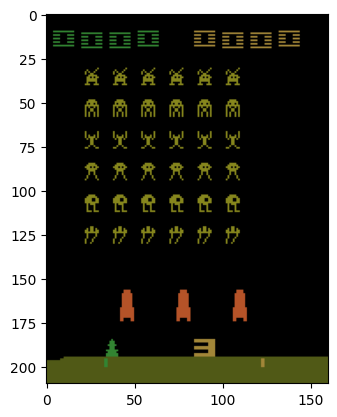

In [16]:
observation = env.reset()
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, reward, done, info = env.step(1)

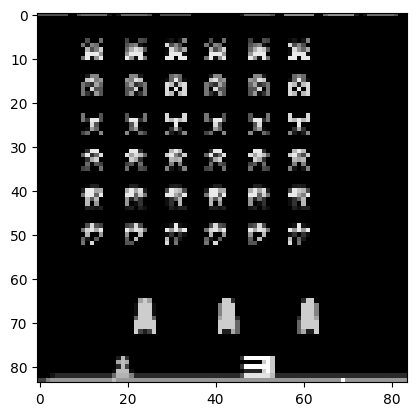

(210, 160, 3)
(84, 84)


In [17]:
# Mostrar las entradas preprocesadas en escala de grises y comparar originales y preprocesados.
processor = AtariProcessor()
obs_preprocessed = processor.process_observation(observation).reshape(INPUT_SHAPE)
# Seleccionamos el primer frame y lo normalizamos
frame = processor.process_state_batch(obs_preprocessed)
# Visualizar en escala de grises
plt.imshow(frame, cmap='gray')
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

#### Clase FrameStack para apilar frames

In [18]:
class FrameStack:
    """
    Clase para gestionar una pila de fotogramas consecutivos del entorno, utilizada para capturar
    el contexto temporal en juegos de Atari (e.g., SpaceInvaders-v0).

    Mantiene una cola (deque) de fotogramas preprocesados con un tamaño máximo definido por
    max_length, apilándolos para formar un estado con información de movimiento.

    Atributos:
    ----------
        frames (deque): Cola de fotogramas preprocesados con longitud máxima max_length.
        max_length (int): Número máximo de fotogramas a apilar (e.g., WINDOW_LENGTH).

    MÉTODOS:
    --------
        append(frame): Añade un nuevo fotograma a la pila, eliminando el más antiguo si es necesario.
        get_stacked_state(): Devuelve el estado apilado como un array NumPy.
    """
    def __init__(self, num_frames=4):
        """
        Inicializa la pila de fotogramas.

        Parámetros:
        -----------
            max_length (int): Número máximo de fotogramas a mantener en la pila.
        """
        self.num_frames = num_frames
        self.frames = deque([np.zeros((INPUT_SHAPE), dtype=np.int) for i in range(self.num_frames)], maxlen=self.num_frames)

    def reset(self):
        self.frames.clear()

    def add_frame(self, frame, is_new_episode):
        """
        Añade un fotograma preprocesado a la pila.

        Parámetros:
        -----------
            frame (np.ndarray): Fotograma preprocesado (e.g., imagen en escala de grises de 84x84).
        """
        # Si es el primer frame, llenamos el deque
        if is_new_episode:
            self.frames = deque([np.zeros((INPUT_SHAPE), dtype=np.int) for i in range(self.num_frames)], maxlen=self.num_frames)
            for _ in range(self.num_frames):
                self.frames.append(frame)
        else:
            self.frames.append(frame)

    def get_state(self):
        """
        Devuelve el estado apilado como un array NumPy con los fotogramas actuales.

        Si la pila no está llena, repite el último fotograma hasta completar max_length.

        Retorna:
        --------
            np.ndarray: Array de forma (84, 84, max_length) con los fotogramas apilados.
        """
        # Convertir a array con shape (84, 84, 4)
        return np.stack(self.frames, axis=-1)

#### Clase ReplayMemory

In [19]:
class ReplayMemory:
    """ReplayMemory optimizada para evitar fugas de memoria"""

    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.position = 0
        self.size = 0

        # Pre-asignar arrays con el tamaño exacto
        # Usar uint8 para estados (más eficiente que float32)
        self.states = np.zeros((capacity, *state_shape), dtype=np.uint8)
        self.actions = np.zeros(capacity, dtype=np.int32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity, *state_shape), dtype=np.uint8)
        self.dones = np.zeros(capacity, dtype=np.bool_)

        print(f"ReplayMemory creada: {capacity} samples, {state_shape} shape")
        memory_size = (
            self.states.nbytes + self.next_states.nbytes +
            self.actions.nbytes + self.rewards.nbytes + self.dones.nbytes
        ) / (1024 * 1024)
        print(f"Memoria asignada: {memory_size:.2f} MB")

    def append(self, state, action, reward, next_state, done):
        """Añade una experiencia al buffer de forma eficiente"""
        # Convertir a uint8 para ahorrar memoria (estados son imágenes 0-255)
        if state.dtype != np.uint8:
            state = (state * 255).astype(np.uint8)
        if next_state.dtype != np.uint8:
            next_state = (next_state * 255).astype(np.uint8)

        # Almacenar directamente en el array pre-asignado
        self.states[self.position] = state
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.next_states[self.position] = next_state
        self.dones[self.position] = done

        # Actualizar posición circular
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """Muestra un batch de experiencias de forma eficiente"""
        if self.size < batch_size:
            raise ValueError(f"No hay suficientes samples ({self.size}) para batch_size ({batch_size})")

        # Generar índices aleatorios
        indices = np.random.choice(self.size, batch_size, replace=False)

        # Extraer batch y convertir de vuelta a float32 para el entrenamiento
        batch_states = self.states[indices].astype(np.float32) / 255.0
        batch_actions = self.actions[indices]
        batch_rewards = self.rewards[indices]
        batch_next_states = self.next_states[indices].astype(np.float32) / 255.0
        batch_dones = self.dones[indices]

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones

    def __len__(self):
        return self.size

    def clear(self):
        """Limpia la memoria de forma segura"""
        self.position = 0
        self.size = 0
        # No es necesario limpiar los arrays, se sobrescriben

#### Clase PerformanceMonitor

In [20]:
# Clase para monitoreo de memoria y rendimiento
class PerformanceMonitor(tf.keras.callbacks.Callback):
    def __init__(self, save_path='diagnosticos'):
        self.save_path = save_path
        self.episode_times = []
        self.memory_usage = []
        self.current_episode = 0
        self.episode_start_time = None
        self.episode_start_memory = None

    def on_episode_begin(self, episode, logs={}):
        self.episode_start_time = time.time()
        self.episode_start_memory = psutil.Process().memory_info().rss / (1024 * 1024)
        self.current_episode = episode
        print(f"Episodio {episode} comenzando. Memoria inicial: {self.episode_start_memory:.2f} MB")

    def on_episode_end(self, episode, logs={}):
        end_time = time.time()
        final_memory = psutil.Process().memory_info().rss / (1024 * 1024)
        episode_duration = end_time - self.episode_start_time

        self.episode_times.append(episode_duration)
        self.memory_usage.append(final_memory)

        print(f"Episodio {episode} completado en {episode_duration:.2f} segundos")
        print(f"Memoria final: {final_memory:.2f} MB (cambio: {final_memory - self.episode_start_memory:.2f} MB)")

        # Guardar diagnóstico cada 5 episodios
        if (episode + 1) % 5 == 0:
            self.save_diagnostics(episode)

        # Forzar recolección de basura
        gc.collect()

    def save_diagnostics(self, episode):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.episode_times)
        plt.title('Tiempo por episodio')
        plt.ylabel('Segundos')
        plt.xlabel('Episodio')

        plt.subplot(1, 2, 2)
        plt.plot(self.memory_usage)
        plt.title('Uso de memoria')
        plt.ylabel('MB')
        plt.xlabel('Episodio')

        plt.tight_layout()
        plt.savefig(f"{self.save_path}/rendimiento_episodio_{episode+1}.png")
        plt.close()

### 1. Implementación de la red neuronal

#### Definición de las redes neuronales

Crearemos una clase para construir un red Q-profunda, con tres capas convolucionales, seguidas de una capa de aplanamiento y una capa completamente conectada.

In [21]:
def create_dqn_model(input_shape, nb_actions, memory_size):
    """
    Crea un modelo DQN usando SOLO Keras estándar. Base común para redes DQN y DDQN
    Red neuronal Deep Q-Network (DQN) para aproximar la función Q en aprendizaje por refuerzo.
    Construye un modelo que acepta channels_first y convierte internamente

    Esta función implementa una red convolucional que recibe un estado (conjunto de frames)
    y produce los valores Q para cada acción posible. Usa capas convolucionales seguidas
    de capas totalmente conectadas, con activación RELU.
    Esto evita completamente los problemas de grafos múltiples
    """
    print(f"🏗️ Creando modelo DQN estándar: input_shape={input_shape}, actions={nb_actions}")
    
    # CRÍTICO: Limpiar completamente antes de crear
    tf.keras.backend.clear_session()
    gc.collect()
       
    # Input en formato channels_first (como viene de SequentialMemory)
    inputs = Input(shape=SEQ_INPUT_SHAPE, name='input_channels_first')  # (4, 84, 84)

    # Convertir a channels_last usando Permute
    x = Permute((2, 3, 1), name='convert_to_channels_last')(inputs)  # (84, 84, 4)
    # Red convolucional estándar
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', padding='valid', name='conv1', input_shape=input_shape)(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', padding='valid', name='conv2')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='valid', name='conv3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='dense1')(x)
    outputs = Dense(nb_actions, activation='linear', name='q_values')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DQN_Model')
    memory = SequentialMemory(limit=memory_size, window_length=WINDOW_LENGTH)
    
    print("✅ Modelo creado exitosamente")
    print(f"📊 Resumen del modelo:")
    model.summary()
    
    return model, memory

In [22]:
def create_ddqn_models(input_shape, nb_actions, memory_size):
    """
    Crea modelos para Double DQN (principal y objetivo)
    """
    print(f"🏗️ Creando modelos DDQN: input_shape={input_shape}, actions={nb_actions}")
    
    # Modelo principal
    main_model, memory = create_dqn_model(input_shape, nb_actions, memory_size)
    main_model._name = 'DDQN_Main_Model'    
    
    # Modelo objetivo (copia exacta)
    target_model = tf.keras.models.clone_model(main_model)
    target_model.set_weights(main_model.get_weights())
    target_model._name = 'DDQN_Target_Model'
    
    print("✅ Modelos DDQN creados exitosamente")    
    return main_model, memory, target_model

In [23]:
def create_ddqn_replay_model(input_shape, action_space, memory_size):
    print(f"🏗️ Creando modelos DDQN_replay: input_shape={input_shape}, actions={nb_actions}")

    # CRÍTICO: Limpiar completamente antes de crear
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Input en formato channels_first (como viene de SequentialMemory)
    inputs = Input(shape=SEQ_INPUT_SHAPE, name='input_channels_first')  # (4, 84, 84)

    # Convertir a channels_last usando Permute
    x = Permute((2, 3, 1), name='convert_to_channels_last')(inputs)  # (84, 84, 4)
    # Red convolucional estándar
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', padding='valid', name='conv1', input_shape=input_shape)(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', padding='valid', name='conv2')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='valid', name='conv3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='dense1')(x)
    outputs = Dense(nb_actions, activation='linear', name='q_values')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DDQN_replay_Main_Model')
    memory = SequentialMemory(limit=memory_size, window_length=WINDOW_LENGTH)
    target_model = clone_model(model)  # Create target model for DDQN
    target_model.set_weights(model.get_weights())  # Initialize with same weights
    target_model._name = 'DDQN_replay_Target_Model'    
    
    print("✅ Modelo creado exitosamente")
    print(f"📊 Resumen del modelo:")
    model.summary()
    return model, memory, target_model

In [24]:
def create_dueling_dqn_replay_model(state_size, action_size, memory_size):
    """
    Crea un modelo Dueling DQN con replay.
    """
    print(f"🏗️ Creando modelo DUELING_DQN_REPLAY: input_shape={state_size}, actions={action_size}")
    # Input en formato channels_first (como viene de SequentialMemory)
    inputs = Input(shape=SEQ_INPUT_SHAPE, name='input_channels_first')  # (4, 84, 84)    
    x = Permute((2, 3, 1))(inputs)
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', padding='valid', input_shape=input_shape)(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', padding='valid')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='valid')(x)
    x = Flatten()(x)
    # Value stream
    value = Dense(512, activation='relu')(x)
    value = Dense(1, activation='linear')(value)
    # Advantage stream
    advantage = Dense(512, activation='relu')(x)
    advantage = Dense(action_size, activation='linear')(advantage)
    # Combine streams
    outputs = Add()([value, Lambda(lambda a: a - K.mean(a, axis=1, keepdims=True))(advantage)])
    model = Model(inputs=inputs, outputs=outputs, name='DuelingDQNReplay_Main_Model')
    memory = SequentialMemory(limit=memory_size, window_length=WINDOW_LENGTH)   
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())    
    target_model._name = 'DuelingDQNReplay_Target_Model'     
   
    print("✅ Modelo creado exitosamente")
    print(f"📊 Resumen del modelo:")
    model.summary()
    return model, memory, target_model

### 2. Implementación de la solución DQN

#### Funciones auxiliares

In [25]:
class SimpleProgressCallback(tf.keras.callbacks.Callback):
    """
    Callback personalizado para monitorear el progreso del entrenamiento de un agente DQN.

    Registra el avance en términos de pasos completados, porcentaje, velocidad de entrenamiento
    (pasos por segundo) y tiempo estimado de finalización (ETA).

    Atributos:
        total_steps (int): Número total de pasos de entrenamiento.
        print_interval (int): Intervalo de pasos para imprimir el progreso (por defecto: 10,000).
        start_time (float): Tiempo de inicio del entrenamiento (en segundos).
        last_step (int): Último paso registrado (inicializado en 0).
    """
    def __init__(self, total_steps, print_interval=100):
        """
        Inicializa el callback.

        Args:
            total_steps (int): Número total de pasos de entrenamiento.
            print_interval (int): Intervalo de pasos para imprimir el progreso.
        """
        super().__init__()
        self.total_steps = total_steps
        self.print_interval = print_interval
        self.step_counter = 0
        self.start_time = time.time()
        self.episode_rewards = []  # Store clipped episode rewards
        self.episode_steps = []
        self.current_episode_reward = 0.0  # Track clipped reward for current episode

    def on_train_begin(self, logs={}):
        """
        Se ejecuta al inicio del entrenamiento.

        Inicializa el tiempo de inicio y muestra un mensaje de comienzo.

        Args:
            logs (dict): Diccionario de métricas (no utilizado aquí).
        """
        self.start_time = time.time()
        print(f"🚀 Entrenamiento iniciado: {self.total_steps:,} pasos")

    def on_step_end(self, step, logs={}):
        """
        Se ejecuta al final de cada paso de entrenamiento.

        Calcula y muestra el progreso, incluyendo porcentaje completado, velocidad
        (pasos por segundo) y tiempo estimado de finalización (ETA) en horas.

        Args:
            step (int): Número del paso actual.
            logs (dict): Diccionario de métricas (no utilizado aquí).
        """
        self.step_counter += 1        
        raw_reward = logs.get('reward', 0.0)
        clipped_reward = np.clip(raw_reward, -1.0, 1.0)  # Match AtariProcessor clipping
        self.current_episode_reward += clipped_reward
        if self.step_counter % self.print_interval == 0:
            progress = (self.step_counter / self.total_steps) * 100
            elapsed_time = (time.time() - self.start_time)
            steps_per_sec = self.step_counter / elapsed_time
            eta_hours = (self.total_steps - self.step_counter) / steps_per_sec / 3600
            memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)
            print(f"📊 Paso {self.step_counter:,}/{self.total_steps:,} ({progress:.1f}%) - "
                  f"{steps_per_sec:.1f} pasos/seg - ETA: {eta_hours:.1f}h - Memoria: {memory_usage:.2f} MB")
    
    def on_episode_end(self, episode, logs={}):
        nb_steps = logs.get('nb_episode_steps', 1)
        self.episode_rewards.append(self.current_episode_reward)
        self.episode_steps.append(nb_steps)
        mean_reward = self.current_episode_reward / nb_steps if nb_steps > 0 else 0
        print(f"📈 Episodio {episode+1}: Recompensa total (clipped): {self.current_episode_reward:.3f}, "
              f"Pasos: {nb_steps}, Mean Reward Calculado: {mean_reward:.6f} (Recompensa/Pasos)")
        # Reset for next episode
        self.current_episode_reward = 0.0            
            

In [26]:
class TargetRewardTracker(tf.keras.callbacks.Callback):
    """
    Callback que monitorea el progreso hacia una media de episode_reward = 20
    """
    def __init__(self, target_avg_reward=TARGET_REWARD, name_model=None, window_size=100, save_best=True):
        super().__init__()
        self.target_avg_reward = target_avg_reward
        self.window_size = window_size
        self.save_best = save_best
        self.name_model = name_model
        
        self.episode_count = 0
        self.episode_rewards = []
        self.best_avg_reward = float('-inf')
        self.episodes_at_target = 0
        self.consecutive_target_episodes = 0
        
        print(f"🎯 OBJETIVO: Media de episode_reward = {target_avg_reward}")
        print(f"📊 Ventana de evaluación: {window_size} episodios")
        self.save_better = f"{self.name_model}_better-trains_{int(time.time())}"
        os.makedirs(self.save_better, exist_ok=True)       
    
    def on_episode_end(self, episode, logs={}):
        self.episode_count += 1
        episode_reward = logs.get('episode_reward', 0)
        self.episode_rewards.append(episode_reward)
        
        # Calcular media móvil
        if len(self.episode_rewards) >= self.window_size:
            recent_rewards = self.episode_rewards[-self.window_size:]
            current_avg = np.mean(recent_rewards)
            
            # Verificar si alcanzamos el objetivo
            target_reached = current_avg >= self.target_avg_reward
            
            if target_reached:
                self.episodes_at_target += 1
                self.consecutive_target_episodes += 1
            else:
                self.consecutive_target_episodes = 0
            
            # Guardar si es el mejor promedio
            if current_avg > self.best_avg_reward:
                self.best_avg_reward = current_avg
                if self.save_best:
                    best_filename = f"{self.save_better}/best_model_avg{current_avg:.1f}_ep{self.episode_count}.h5"
                    self.model.save_weights(best_filename, overwrite=True)
                    print(f"💾 NUEVO MEJOR PROMEDIO: {current_avg:.2f} - Guardado: {best_filename}")
            
            # Mostrar progreso cada 50 episodios
            if self.episode_count % 50 == 0:
                progress_pct = (current_avg / self.target_avg_reward) * 100
                target_status = "🎯 OBJETIVO ALCANZADO!" if target_reached else f"📈 {progress_pct:.1f}% del objetivo"
                
                print(f"\n📊 EPISODIO {self.episode_count} - PROGRESO HACIA OBJETIVO")
                print(f"   Reward actual: {episode_reward:.2f}")
                print(f"   Media últimos {self.window_size}: {current_avg:.2f} / {self.target_avg_reward}")
                print(f"   Mejor promedio histórico: {self.best_avg_reward:.2f}")
                print(f"   Estado: {target_status}")
                print(f"   Episodios en objetivo: {self.episodes_at_target}")
                print(f"   Episodios consecutivos en objetivo: {self.consecutive_target_episodes}")
                
                if self.consecutive_target_episodes >= 50:
                    print(f"🏆 ¡MODELO ESTABLE EN OBJETIVO! {self.consecutive_target_episodes} episodios consecutivos")
    
    def on_train_end(self, logs={}):
        """Resumen final del entrenamiento"""
        if len(self.episode_rewards) >= self.window_size:
            final_avg = np.mean(self.episode_rewards[-self.window_size:])
            objetivo_alcanzado = final_avg >= self.target_avg_reward
            
            print(f"\n🏁 RESUMEN FINAL DEL ENTRENAMIENTO")
            print(f"   Total episodios: {self.episode_count}")
            print(f"   Media final últimos {self.window_size}: {final_avg:.2f}")
            print(f"   Objetivo ({self.target_avg_reward}): {'✅ ALCANZADO' if objetivo_alcanzado else '❌ NO ALCANZADO'}")
            print(f"   Mejor promedio histórico: {self.best_avg_reward:.2f}")
            print(f"   Episodios que alcanzaron objetivo: {self.episodes_at_target}")

In [27]:
class TargetRewardTracker(tf.keras.callbacks.Callback):
    """
    Callback que monitorea el progreso hacia una media de episode_reward = 20
    """
    def __init__(self, target_avg_reward=20.0, name_model=None, window_size=100, save_best=True):
        super().__init__()
        self.target_avg_reward = target_avg_reward
        self.window_size = window_size
        self.save_best = save_best
        self.name_model = name_model or "model"
        self.episode_count = 0
        self.episode_rewards = []
        self.best_avg_reward = float('-inf')
        self.episodes_at_target = 0
        self.consecutive_target_episodes = 0
        self.save_better = f"{self.name_model}_better-trains_{int(time.time())}"
        os.makedirs(self.save_better, exist_ok=True)
        
        print(f"🎯 OBJETIVO: Media de episode_reward = {target_avg_reward}")
        print(f"📊 Ventana de evaluación: {window_size} episodios")

    def on_episode_end(self, episode, logs=None):
        logs = logs or {}
        
        self.episode_count += 1
        episode_reward = logs.get('episode_reward', 0)
        # Convert NumPy types to Python types
        if isinstance(episode_reward, np.floating):
            episode_reward = episode_reward.item()
        self.episode_rewards.append(episode_reward)
        
        # Calcular media móvil
        if len(self.episode_rewards) >= self.window_size:
            recent_rewards = self.episode_rewards[-self.window_size:]
            current_avg = np.mean(recent_rewards)
            
            # Verificar si alcanzamos el objetivo
            target_reached = current_avg >= self.target_avg_reward
            
            if target_reached:
                self.episodes_at_target += 1
                self.consecutive_target_episodes += 1
            else:
                self.consecutive_target_episodes = 0
            
            # Guardar si es el mejor promedio
            if current_avg > self.best_avg_reward:
                self.best_avg_reward = current_avg
                if self.save_best:
                    best_filename = f"{self.save_better}/best_model_avg{current_avg:.1f}_ep{self.episode_count}.h5f"
                    try:
                        self.model.save_weights(best_filename, overwrite=True)
                        # Save metrics to JSON
                        metrics = {
                            "episode": int(self.episode_count),  # Cast to Python int
                            "avg_reward": float(current_avg),   # Cast to Python float
                            "best_avg_reward": float(self.best_avg_reward),
                            "timestamp": int(time.time())
                        }
                        with open(f"{best_filename}.json", 'w') as f:
                            json.dump(metrics, f, indent=2, default=str)
                        print(f"💾 NUEVO MEJOR PROMEDIO: {current_avg:.2f} - Guardado: {best_filename}")
                    except Exception as e:
                        print(f"⚠️ Error saving best model: {e}")
            
            # Mostrar progreso cada 50 episodios
            if self.episode_count % 50 == 0:
                progress_pct = (current_avg / self.target_avg_reward) * 100
                target_status = "🎯 OBJETIVO ALCANZADO!" if target_reached else f"📈 {progress_pct:.1f}% del objetivo"
                
                print(f"\n📊 EPISODIO {self.episode_count} - PROGRESO HACIA OBJETIVO")
                print(f"   Reward actual: {episode_reward:.2f}")
                print(f"   Media últimos {self.window_size}: {current_avg:.2f} / {self.target_avg_reward}")
                print(f"   Mejor promedio histórico: {self.best_avg_reward:.2f}")
                print(f"   Estado: {target_status}")
                print(f"   Episodios en objetivo: {self.episodes_at_target}")
                print(f"   Episodios consecutivos en objetivo: {self.consecutive_target_episodes}")
                
                if self.consecutive_target_episodes >= 50:
                    print(f"🏆 ¡MODELO ESTABLE EN OBJETIVO! {self.consecutive_target_episodes} episodios consecutivos")
    
    def on_train_end(self, logs=None):
        logs = logs or {}    
        """Resumen final del entrenamiento"""
        if len(self.episode_rewards) >= self.window_size:
            final_avg = np.mean(self.episode_rewards[-self.window_size:])
            objetivo_alcanzado = final_avg >= self.target_avg_reward
            
            print(f"\n🏁 RESUMEN FINAL DEL ENTRENAMIENTO")
            print(f"   Total episodios: {self.episode_count}")
            print(f"   Media final últimos {self.window_size}: {final_avg:.2f}")
            print(f"   Objetivo ({self.target_avg_reward}): {'✅ ALCANZADO' if objetivo_alcanzado else '❌ NO ALCANZADO'}")
            print(f"   Mejor promedio histórico: {self.best_avg_reward:.2f}")
            print(f"   Episodios que alcanzaron objetivo: {self.episodes_at_target}")
            
            # Save final metrics to JSON
            final_metrics = {
                "total_episodes": int(self.episode_count),
                "final_avg_reward": float(final_avg),
                "target_reached": bool(objetivo_alcanzado),
                "best_avg_reward": float(self.best_avg_reward),
                "episodes_at_target": int(self.episodes_at_target)
            }
            final_log_path = f"{self.save_better}/final_metrics.json"
            try:
                with open(final_log_path, 'w') as f:
                    json.dump(final_metrics, f, indent=2, default=str)                                    
                print(f"💾 Métricas finales guardadas en: {final_log_path}")
            except Exception as e:
                print(f"⚠️ Error saving final metrics: {e}")

In [28]:
class CustomFileLogger(FileLogger):
    def __init__(self, filepath, interval=100):
        super().__init__(filepath, interval)
        self.step = 0  
        self.filepath = filepath
        self.interval = interval
        self.current_episode_reward = 0.0
        self.logs = {}        
    
    def on_step_end(self, step, logs={}):
        self.step += 1  
        if self.step % self.interval == 0:
            episode_logs = {}
        raw_reward = logs.get('reward', 0.0)
        self.current_episode_reward += np.clip(raw_reward, -1.0, 1.0)

    def on_episode_end(self, episode, logs):
        metrics = logs.copy()
        metrics['episode_reward'] = self.current_episode_reward
        metrics['mean_reward_step'] = self.current_episode_reward / metrics.get('nb_episode_steps', 1)
        metrics = {k: float(v) if isinstance(v, np.floating) else v for k, v in metrics.items()}
        self.metrics[int(episode)] = metrics
        if self.step % self.interval == 0:
            with open(self.filepath, 'w') as f:
                json.dump(self.metrics, f, indent=2, default=str)                
        self.current_episode_reward = 0.0

In [29]:
class EpisodeCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, dqnet, checkpoint_path, save_freq=100, model_name='DQN'):
        super().__init__()
        self.checkpoint_path = checkpoint_path
        self.save_freq = save_freq
        self.model_name = model_name
        self.episode_counter = 0
        self.dqnet = dqnet
        os.makedirs(checkpoint_path, exist_ok=True)
    
    def on_episode_end(self, episode, logs={}):
        self.episode_counter += 1
        if self.episode_counter % self.save_freq == 0:
            weights_filename = f"{self.checkpoint_path}/{self.model_name}_weights_episode_{self.episode_counter}.h5f"
            try:
                self.model.save_weights(weights_filename, overwrite=True)
                print(f"✅ Pesos guardados en {weights_filename} tras el episodio {self.episode_counter}")
                
                # Guardar memoria de repetición para modelos con replay                                
                if self.model_name in ['DDQN_REPLAY', 'DUELING_DQN_REPLAY']:
                    weights_filename = f"{self.checkpoint_path}/{self.model_name}_memory_episode_{self.episode_counter}.pkl"
                    try:
                        with open(self.checkpoint_path, 'wb') as f:
                            pickle.dump(self.dqnet.memory, f)
                        print(f"💾 Memoria guardada: {self.checkpoint_path}")
                    except Exception as e:
                        print(f"⚠️ Error guardando memoria: {e}")                
                
            except Exception as e:
                print(f"❌ Error al guardar pesos en {weights_filename}: {str(e)}")

In [30]:
def save_checkpoint_memory(dqnet, model_type, suffix="final", checkpoint_path="checkpoints"):
    """
    Guarda los pesos del modelo y, si aplica, la memoria de repetición en archivos.

    Esta función guarda los pesos de un modelo de red neuronal en un archivo HDF5 (.h5) y, para modelos con memoria
    de repetición (como DDQNetworkWithReplay o DuelingDQNetworkWithReplay), guarda la memoria en un archivo pickle (.pkl).
    Los archivos se nombran usando un prefijo basado en la clase del modelo y el número de episodio, siguiendo el formato
    `{prefijo}_checkpoint_ep{episode}.h5` para pesos y `{prefijo}_memory_ep{episode}.pkl` para memoria.

    Parámetros:
    -----------
        dqnet: Objeto del modelo de red neuronal, como una instancia de DQNetwork, DDQNetwork, DDQNetworkWithReplay o
            DuelingDQNetworkWithReplay. Debe tener un método `save_weights` para guardar pesos y, si usa memoria, un
            atributo `memory`.
        model_type: Clase del modelo (e.g., DQNetwork, DDQNetwork, DDQNetworkWithReplay, DuelingDQNetworkWithReplay).
            Se usa para determinar el prefijo del nombre de archivo y verificar si el modelo soporta memoria de repetición.     
        episode: int. Número del episodio actual del entrenamiento. Se usa para nombrar los archivos de checkpoint y
            memoria (e.g., `checkpoint_ep10.h5` para el episodio 10).
        checkpoint_dir: str, opcional. Directorio donde se guardan los archivos de checkpoint y memoria
            (e.g., 'checkpoints'). Se crea el directorio si no existe. Por defecto es "checkpoints".

    Retorna:
    --------
        None

    Raises:
        KeyError: Si `dqnet_class` no está en el mapeo interno de clases a prefijos.
        Exception: Captura y registra errores durante la escritura de archivos, pero no interrumpe la ejecución.
    """
    # Crear directorio de checkpoints si no existe
    # os.makedirs(checkpoint_path, exist_ok=True)
    memory_path_save = None

    try:
        # Guardar pesos del modelo
        checkpoint_path_save =  f"{checkpoint_path}/{model_type}_weights_{suffix}.h5"
        dqnet.main_network.save_weights(checkpoint_path_save)
        print(f"💾 Guardado modelo {suffix}: {checkpoint_path_save}")

        # Guardar memoria de repetición para modelos con replay
        if model_type in ['DDQN_REPLAY', 'DUELING_DQN_REPLAY']:
            memory_path_save = os.path.join(checkpoint_path, f'{model_type}_memory_{suffix}.pkl')
            try:
                with open(memory_path_save, 'wb') as f:
                    pickle.dump(dqnet.memory, f)
                print(f"💾 Memoria {suffix} guardada: {memory_path_save}")
            except Exception as e:
                print(f"⚠️ Error guardando memoria {suffix}: {e}")

    except Exception as e:
        print(f"⚠️ Error guardando checkpoint {suffix}: {e}")

    return

#### **ENTRENAMIENTO** ***********

In [31]:
def entrenar_modelo(env, model_type, model_process, batch_size=batch_size, learning_rate=learning_rate, checkpoint_path='checkpoints',
        input_shape=MODEL_INPUT_SHAPE, memoria_tamano=memory_size, warmup_steps=WARMUP_STEPS,
        target_update_interval=TARGET_UPDATE_INTERVAL, target_update_tau=tau, epsilon_start=epsilon_start,
        epsilon_min=0.1, epsilon_steps=EPSILON_STEPS, num_steps=NUM_TRAINING_STEPS, target_reward=TARGET_REWARD):
    """
    Agente simple con conversión automática - NO toca AtariProcessor
    """
    name_model = model_type.upper()    
    print(f"🤖 Creando agente {name_model} con conversión automática...")
    
    # Limpiar
    tf.keras.backend.clear_session()
    gc.collect()
    model = None

    # Crear el procesador Atari
    processor = AtariProcessor()
    # Verificar el tipo de modelo y establecer enable_double_dqn correctamente
    enable_double_dqn = name_model in ['DDQN', 'DDQN_REPLAY', 'DUELING_DQN_REPLAY']

    print("-" * 60)    
    try:
        if enable_double_dqn:
            model, memory, target_model = model_process(input_shape, env.action_space.n, memoria_tamano)
        else:
            model, memory = model_process(input_shape, env.action_space.n, memoria_tamano)
            target_model = None
       
        if model is None:
            raise ValueError("El modelo no se creó correctamente.")
   
    except Exception as e:
        print(f"❌ Error al crear el modelo: {str(e)}")
        return None, False
    
    memory = SequentialMemory(limit=memoria_tamano, window_length=WINDOW_LENGTH)
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                                attr='eps',
                                value_max=epsilon_start, 
                                value_min=epsilon_min, 
                                value_test=.05,
                                nb_steps=epsilon_steps)  
    # Crear agente
    try:
        dqn = DQNAgent(
            model=model,
            nb_actions=env.action_space.n,
            memory=memory,
            processor=processor,
            nb_steps_warmup=warmup_steps,
            target_model_update=TARGET_UPDATE_INTERVAL if enable_double_dqn else 10000,  # Hard update every 10,000 steps
            enable_double_dqn=enable_double_dqn,
            gamma=gamma,
            train_interval=4,
            delta_clip=1.0,
            batch_size=batch_size
        )

        # Compilar el agente
        dqn.compile(Adam(learning_rate=learning_rate), metrics=['mae'])
        
    except Exception as e:
        print(f"❌ Error al crear o compilar el agente: {str(e)}")
        return None, False

    # Configurar callbacks
    tipo_str = name_model
    weights_filename = f'{tipo_str}_weights.h5f'
    checkpoint_weights_filename = f'{checkpoint_path}/{tipo_str}_weights_{{step}}.h5f'
    log_filename = f'{checkpoint_path}/{tipo_str}_log.json'

    # DEBUG --------------------
    # callbacks = [
    #     progress_callback,
    #     ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000),
    #     CustomFileLogger(log_filename, interval=1000),
    #     PerformanceMonitor(save_path='diagnosticos')
    # ]
    # Callbacks optimizados para el objetivo
    training_dir = f"{checkpoint_path}/{name_model}"
    callbacks = [
            #ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000),      
            CustomFileLogger(log_filename, interval=1000),
            # Progreso cada 20k pasos
            SimpleProgressCallback(num_steps, print_interval=20000),         
            # Tracker del objetivo principal
            TargetRewardTracker( target_avg_reward=target_reward, name_model=training_dir, window_size=100, save_best=True),
            EpisodeCheckpointCallback(dqn, checkpoint_path=checkpoint_path, save_freq=100, model_name=tipo_str)    
        ]
    
    try:
        print(f"Iniciando entrenamiento de {tipo_str} por {num_steps} pasos...")
        start_time = time.time()
        trained_dqn = dqn.fit(env, nb_steps=num_steps, callbacks=callbacks, verbose=2)
        training_time = (time.time() - start_time) / 60
        print(f"Entrenamiento completado en {training_time:.2f} minutos")
        
        # Guardar pesos finales
        save_checkpoint_memory(dqn, name_model)
        return trained_dqn, True
    except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido por el usuario") 
        # Guardar pesos de emergencia
        save_checkpoint_memory(dqn, name_model, suffix="emergency")        
        return trained_dqn, True
    except Exception as e:
        print(f"\nError durante el entrenamiento: {str(e)}")
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, False

#### **EVALUACION** ***********

In [32]:
# Función para evaluar el modelo
def evaluar_modelo(dqn, env, num_episodes=200, render=True, record_video=False):
    """
    Evalúa un modelo DQN o DDQN y si el modelo alcanza el objetivo de media

    Args:
        dqn: Agente DQN entrenado
        env: Entorno de gym
        num_episodes: Número de episodios para evaluar
        render: Si se debe mostrar la visualización
        record_video: Si se debe grabar video

    Returns:
        Lista de recompensas por episodio
    """
    print(f"🎯 EVALUANDO OBJETIVO: Media de episode_reward = {TARGET_REWARD}")
    print(f"📊 Evaluando por {num_episodes} episodios...")
    
    rewards = []
    
    try:
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False
            steps = 0
            
            while not done and steps < 2000:  # Límite de pasos por episodio
                action = dqn.forward(state)
                state, reward, done, _ = env.step(action)
                total_reward += reward
                steps += 1
            
            rewards.append(total_reward)
            
            if (episode + 1) % 50 == 0:
                current_avg = np.mean(rewards)
                print(f"   Episodio {episode + 1}: avg actual = {current_avg:.2f}")
        
        # Análisis final
        avg_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        max_reward = np.max(rewards)
        min_reward = np.min(rewards)
        
        objetivo_alcanzado = avg_reward >= 20.0
        
        print(f"\n📊 RESULTADOS DE EVALUACIÓN:")
        print(f"   Media: {avg_reward:.2f} {'✅' if objetivo_alcanzado else '❌'}")
        print(f"   Desviación: ±{std_reward:.2f}")
        print(f"   Máximo: {max_reward:.2f}")
        print(f"   Mínimo: {min_reward:.2f}")
        print(f"   Episodios sobre 20: {sum(1 for r in rewards if r >= 20)} / {num_episodes}")
        
        if objetivo_alcanzado:
            print(f"🏆 ¡OBJETIVO ALCANZADO! El modelo tiene una media de {avg_reward:.2f}")
        else:
            print(f"📈 Progreso: {(avg_reward/20)*100:.1f}% del objetivo")
        
        return rewards, objetivo_alcanzado
        
    except Exception as e:
        print(f"❌ Error durante evaluación: {e}")
        return [], False

### ¡¡¡¡¡¡¡ **EJECUCION - MAIN** !!!!!!!

In [ ]:
# --- Bloque de Ejecución Principal ---
if __name__ == "__main__":
    tf.keras.backend.clear_session()
    # Control global de si se entrena o solo se carga
    training_global = True
    # Control de renderizado durante el entrenamiento (no afecta la grabación de video final)
    episode_render = False
    # Asegurar que existe el directorio
    os.makedirs(checkpoint_path, exist_ok=True)
    # Optimizar configuración de TensorFlow
    optimizar_tensorflow()
    tf.config.run_functions_eagerly(False)
    gc.collect()    

    # ------------ ENTRENAMIENTO Y CARGA DE MEJORES MODELOS --------------------------------------
    # Ejecutar prueba
    print("🚀 EJECUTANDO SOLUCIÓN...")
    print(f"🎯 OBJETIVO: Conseguir media de episode_reward = {TARGET_REWARD} (con clipping)")    
    
    # Diccionario para guardar los *mejores modelos cargados/entrenados* de cada tipo
    trained_models = {}
    # Lista de tuplas (nombre_modelo, clase_modelo, flag_entrenamiento_especifico)
    modelos_a_procesar = [
        ('DQN', create_dqn_model, False),
        ('DDQN', create_ddqn_models, True),
        ('DDQN_REPLAY', create_ddqn_replay_model, False),
        ('DUELING_DQN_REPLAY', create_dueling_dqn_replay_model, False)
    ]
    
    for model_name, model_process, training_specific_flag in modelos_a_procesar:
        # La bandera de entrenamiento final es la global AND la específica del modelo
        entrenarSN = training_global and training_specific_flag
        model_instance = None
        if entrenarSN:
            episode_weights = sorted(
                [f for f in os.listdir(checkpoint_path) if f.startswith(f"{model_name}_weights_episode_")],
                key=lambda x: int(re.search(r'episode_(\d+)', x).group(1)) if re.search(r'episode_(\d+)', x) else 0
            )
            if episode_weights:
                latest_weights = os.path.join(checkpoint_path, episode_weights[-1])
                print(f"Cargando pesos desde {latest_weights}")
                dqn_auto, success_auto = entrenar_modelo(
                    env, model_name, model_process, batch_size=batch_size, learning_rate=learning_rate,
                    checkpoint_path=checkpoint_path, input_shape=MODEL_INPUT_SHAPE, memoria_tamano=memory_size,
                    warmup_steps=WARMUP_STEPS, target_update_interval=TARGET_UPDATE_INTERVAL, target_update_tau=tau,
                    epsilon_start=epsilon_start, epsilon_min=epsilon_stop, epsilon_steps=EPSILON_STEPS, num_steps=NUM_TRAINING_STEPS
                )
                if dqn_auto:
                    dqn_auto.load_weights(latest_weights)
                    model_instance = dqn_auto
            else:
                model_instance, success_auto = entrenar_modelo(
                    env, model_name, model_process, batch_size=batch_size, learning_rate=learning_rate,
                    checkpoint_path=checkpoint_path, input_shape=MODEL_INPUT_SHAPE, memoria_tamano=memory_size,
                    warmup_steps=WARMUP_STEPS, target_update_interval=TARGET_UPDATE_INTERVAL, target_update_tau=tau,
                    epsilon_start=epsilon_start, epsilon_min=epsilon_stop, epsilon_steps=EPSILON_STEPS, num_steps=NUM_TRAINING_STEPS
                )
            if model_instance:
                rewards = evaluar_modelo(model_instance, env, num_episodes=10, render=False, record_video=False)
                print(f"Recompensa promedio para {model_name}: {np.mean(rewards):.2f}")
                trained_models[model_name] = model_instance  
                
    if model_instance:
        print("\n✅ SOLUCIÓN EXITOSA - Entrenamiento completado")
        print(f"📁 Archivos en: {checkpoint_path}/{model_name}")

        # Evaluación final
        print(f"\n🎯 EVALUACIÓN FINAL DEL OBJETIVO")
        rewards_eval, objetivo_conseguido = evaluar_modelo(dqn_auto, num_episodes=200)

        if objetivo_conseguido:
            print(f"🏆 ¡FELICIDADES EQUIPO! El modelo alcanzó el objetivo de media 20")
        else:
            print(f"📈 El modelo necesita más entrenamiento para alcanzar media 20")

    else:
        print(f"❌ Error en el entrenamiento")        

TensorFlow optimizado para 20 cores CPU
🚀 EJECUTANDO SOLUCIÓN...
🎯 OBJETIVO: Conseguir media de episode_reward = 20.0 (con clipping)
Cargando pesos desde checkpoints\DDQN_weights_episode_200.h5f.index
🤖 Creando agente DDQN con conversión automática...
------------------------------------------------------------
🏗️ Creando modelos DDQN: input_shape=(84, 84, 4), actions=6
🏗️ Creando modelo DQN estándar: input_shape=(84, 84, 4), actions=6
✅ Modelo creado exitosamente
📊 Resumen del modelo:
Model: "DQN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_channels_first (Input  [(None, 4, 84, 84)]      0         
 Layer)                                                          
                                                                 
 convert_to_channels_last (P  (None, 84, 84, 4)        0         
 ermute)                                                         
                            

D:\90-Tools\anaconda3\envs\mghMiar08\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


📈 Episodio 1: Recompensa total (clipped): 20.000, Pasos: 649, Mean Reward Calculado: 0.030817 (Recompensa/Pasos)
     649/5000000: episode: 1, duration: 4.520s, episode steps: 649, steps per second: 144, episode reward: 20.000, mean reward:  0.031 [ 0.000,  1.000], mean action: 3.641 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 2: Recompensa total (clipped): 19.000, Pasos: 659, Mean Reward Calculado: 0.028832 (Recompensa/Pasos)
    1308/5000000: episode: 2, duration: 4.560s, episode steps: 659, steps per second: 145, episode reward: 19.000, mean reward:  0.029 [ 0.000,  1.000], mean action: 3.231 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 3: Recompensa total (clipped): 17.000, Pasos: 679, Mean Reward Calculado: 0.025037 (Recompensa/Pasos)
    1987/5000000: episode: 3, duration: 4.520s, episode steps: 679, steps per second: 150, episode reward: 17.000, mean reward:  0.025 [ 0.000,  1.000], mean action: 3.672 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Ep

📈 Episodio 26: Recompensa total (clipped): 14.000, Pasos: 613, Mean Reward Calculado: 0.022838 (Recompensa/Pasos)
   15740/5000000: episode: 26, duration: 4.217s, episode steps: 613, steps per second: 145, episode reward: 14.000, mean reward:  0.023 [ 0.000,  1.000], mean action: 3.330 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 27: Recompensa total (clipped): 9.000, Pasos: 497, Mean Reward Calculado: 0.018109 (Recompensa/Pasos)
   16237/5000000: episode: 27, duration: 3.488s, episode steps: 497, steps per second: 142, episode reward:  9.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 3.300 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 28: Recompensa total (clipped): 6.000, Pasos: 370, Mean Reward Calculado: 0.016216 (Recompensa/Pasos)
   16607/5000000: episode: 28, duration: 2.700s, episode steps: 370, steps per second: 137, episode reward:  6.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.857 [0.000, 5.000],  loss: --, mae: --, mean_q: --


📈 Episodio 51: Recompensa total (clipped): 14.000, Pasos: 502, Mean Reward Calculado: 0.027888 (Recompensa/Pasos)
   30520/5000000: episode: 51, duration: 3.600s, episode steps: 502, steps per second: 139, episode reward: 14.000, mean reward:  0.028 [ 0.000,  1.000], mean action: 3.369 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 52: Recompensa total (clipped): 13.000, Pasos: 557, Mean Reward Calculado: 0.023339 (Recompensa/Pasos)
   31077/5000000: episode: 52, duration: 3.678s, episode steps: 557, steps per second: 151, episode reward: 13.000, mean reward:  0.023 [ 0.000,  1.000], mean action: 3.447 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 53: Recompensa total (clipped): 9.000, Pasos: 511, Mean Reward Calculado: 0.017613 (Recompensa/Pasos)
   31588/5000000: episode: 53, duration: 3.621s, episode steps: 511, steps per second: 141, episode reward:  9.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 3.096 [0.000, 5.000],  loss: --, mae: --, mean_q: --

📈 Episodio 76: Recompensa total (clipped): 20.000, Pasos: 685, Mean Reward Calculado: 0.029197 (Recompensa/Pasos)
   45426/5000000: episode: 76, duration: 4.780s, episode steps: 685, steps per second: 143, episode reward: 20.000, mean reward:  0.029 [ 0.000,  1.000], mean action: 3.358 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 77: Recompensa total (clipped): 12.000, Pasos: 722, Mean Reward Calculado: 0.016620 (Recompensa/Pasos)
   46148/5000000: episode: 77, duration: 4.956s, episode steps: 722, steps per second: 146, episode reward: 12.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 2.632 [0.000, 5.000],  loss: --, mae: --, mean_q: --
📈 Episodio 78: Recompensa total (clipped): 17.000, Pasos: 600, Mean Reward Calculado: 0.028333 (Recompensa/Pasos)
   46748/5000000: episode: 78, duration: 4.194s, episode steps: 600, steps per second: 143, episode reward: 17.000, mean reward:  0.028 [ 0.000,  1.000], mean action: 3.525 [0.000, 5.000],  loss: --, mae: --, mean_q: -

D:\90-Tools\anaconda3\envs\mghMiar08\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


📈 Episodio 83: Recompensa total (clipped): 16.000, Pasos: 751, Mean Reward Calculado: 0.021305 (Recompensa/Pasos)
   50064/5000000: episode: 83, duration: 10.306s, episode steps: 751, steps per second:  73, episode reward: 16.000, mean reward:  0.021 [ 0.000,  1.000], mean action: 3.613 [0.000, 5.000],  loss: 0.012944, mae: 0.028648, mean_q: 0.062642
📈 Episodio 84: Recompensa total (clipped): 18.000, Pasos: 574, Mean Reward Calculado: 0.031359 (Recompensa/Pasos)
   50638/5000000: episode: 84, duration: 35.834s, episode steps: 574, steps per second:  16, episode reward: 18.000, mean reward:  0.031 [ 0.000,  1.000], mean action: 3.571 [0.000, 5.000],  loss: 0.011139, mae: 0.020085, mean_q: 0.036276
📈 Episodio 85: Recompensa total (clipped): 3.000, Pasos: 273, Mean Reward Calculado: 0.010989 (Recompensa/Pasos)
   50911/5000000: episode: 85, duration: 16.245s, episode steps: 273, steps per second:  17, episode reward:  3.000, mean reward:  0.011 [ 0.000,  1.000], mean action: 3.586 [0.000,

📈 Episodio 105: Recompensa total (clipped): 14.000, Pasos: 681, Mean Reward Calculado: 0.020558 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 14.60 - Guardado: checkpoints/DDQN_better-trains_1750663521/best_model_avg14.6_ep105.h5f
   63598/5000000: episode: 105, duration: 43.804s, episode steps: 681, steps per second:  16, episode reward: 14.000, mean reward:  0.021 [ 0.000,  1.000], mean action: 2.465 [0.000, 5.000],  loss: 0.010241, mae: 0.045374, mean_q: 0.065608
📈 Episodio 106: Recompensa total (clipped): 10.000, Pasos: 626, Mean Reward Calculado: 0.015974 (Recompensa/Pasos)
   64224/5000000: episode: 106, duration: 39.593s, episode steps: 626, steps per second:  16, episode reward: 10.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.449 [0.000, 5.000],  loss: 0.011472, mae: 0.050803, mean_q: 0.071816
📈 Episodio 107: Recompensa total (clipped): 5.000, Pasos: 311, Mean Reward Calculado: 0.016077 (Recompensa/Pasos)
   64535/5000000: episode: 107, duration: 19.852s, episode step

📈 Episodio 128: Recompensa total (clipped): 18.000, Pasos: 944, Mean Reward Calculado: 0.019068 (Recompensa/Pasos)
   75537/5000000: episode: 128, duration: 58.056s, episode steps: 944, steps per second:  16, episode reward: 18.000, mean reward:  0.019 [ 0.000,  1.000], mean action: 1.980 [0.000, 5.000],  loss: 0.010848, mae: 0.073765, mean_q: 0.104114
📈 Episodio 129: Recompensa total (clipped): 13.000, Pasos: 567, Mean Reward Calculado: 0.022928 (Recompensa/Pasos)
   76104/5000000: episode: 129, duration: 34.749s, episode steps: 567, steps per second:  16, episode reward: 13.000, mean reward:  0.023 [ 0.000,  1.000], mean action: 1.880 [0.000, 5.000],  loss: 0.009801, mae: 0.074698, mean_q: 0.105959
📈 Episodio 130: Recompensa total (clipped): 5.000, Pasos: 303, Mean Reward Calculado: 0.016502 (Recompensa/Pasos)
   76407/5000000: episode: 130, duration: 18.799s, episode steps: 303, steps per second:  16, episode reward:  5.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 3.686 [

📈 Episodio 151: Recompensa total (clipped): 13.000, Pasos: 604, Mean Reward Calculado: 0.021523 (Recompensa/Pasos)
   88486/5000000: episode: 151, duration: 35.497s, episode steps: 604, steps per second:  17, episode reward: 13.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 2.043 [0.000, 5.000],  loss: 0.008617, mae: 0.109476, mean_q: 0.148696
📈 Episodio 152: Recompensa total (clipped): 9.000, Pasos: 404, Mean Reward Calculado: 0.022277 (Recompensa/Pasos)
   88890/5000000: episode: 152, duration: 23.361s, episode steps: 404, steps per second:  17, episode reward:  9.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 3.480 [0.000, 5.000],  loss: 0.008078, mae: 0.103216, mean_q: 0.142767
📈 Episodio 153: Recompensa total (clipped): 22.000, Pasos: 628, Mean Reward Calculado: 0.035032 (Recompensa/Pasos)
   89518/5000000: episode: 153, duration: 37.685s, episode steps: 628, steps per second:  17, episode reward: 22.000, mean reward:  0.035 [ 0.000,  1.000], mean action: 2.745 [

📈 Episodio 174: Recompensa total (clipped): 9.000, Pasos: 502, Mean Reward Calculado: 0.017928 (Recompensa/Pasos)
  100281/5000000: episode: 174, duration: 32.411s, episode steps: 502, steps per second:  15, episode reward:  9.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.215 [0.000, 5.000],  loss: 0.008686, mae: 0.145304, mean_q: 0.195177
📈 Episodio 175: Recompensa total (clipped): 4.000, Pasos: 292, Mean Reward Calculado: 0.013699 (Recompensa/Pasos)
  100573/5000000: episode: 175, duration: 18.420s, episode steps: 292, steps per second:  16, episode reward:  4.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.740 [0.000, 5.000],  loss: 0.011072, mae: 0.158812, mean_q: 0.212269
📈 Episodio 176: Recompensa total (clipped): 19.000, Pasos: 805, Mean Reward Calculado: 0.023602 (Recompensa/Pasos)
  101378/5000000: episode: 176, duration: 49.648s, episode steps: 805, steps per second:  16, episode reward: 19.000, mean reward:  0.024 [ 0.000,  1.000], mean action: 2.851 [0

📈 Episodio 198: Recompensa total (clipped): 9.000, Pasos: 503, Mean Reward Calculado: 0.017893 (Recompensa/Pasos)
  112998/5000000: episode: 198, duration: 33.881s, episode steps: 503, steps per second:  15, episode reward:  9.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.942 [0.000, 5.000],  loss: 0.007968, mae: 0.178436, mean_q: 0.233417
📈 Episodio 199: Recompensa total (clipped): 7.000, Pasos: 379, Mean Reward Calculado: 0.018470 (Recompensa/Pasos)
  113377/5000000: episode: 199, duration: 24.796s, episode steps: 379, steps per second:  15, episode reward:  7.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.301 [0.000, 5.000],  loss: 0.008483, mae: 0.173124, mean_q: 0.225107
📈 Episodio 200: Recompensa total (clipped): 9.000, Pasos: 503, Mean Reward Calculado: 0.017893 (Recompensa/Pasos)

📊 EPISODIO 200 - PROGRESO HACIA OBJETIVO
   Reward actual: 9.00
   Media últimos 100: 11.50 / 20.0
   Mejor promedio histórico: 14.69
   Estado: 📈 57.5% del objetivo
   Episodio

📈 Episodio 220: Recompensa total (clipped): 17.000, Pasos: 501, Mean Reward Calculado: 0.033932 (Recompensa/Pasos)
  125765/5000000: episode: 220, duration: 34.630s, episode steps: 501, steps per second:  14, episode reward: 17.000, mean reward:  0.034 [ 0.000,  1.000], mean action: 2.848 [0.000, 5.000],  loss: 0.007708, mae: 0.196541, mean_q: 0.253792
📈 Episodio 221: Recompensa total (clipped): 13.000, Pasos: 583, Mean Reward Calculado: 0.022298 (Recompensa/Pasos)
  126348/5000000: episode: 221, duration: 40.387s, episode steps: 583, steps per second:  14, episode reward: 13.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 2.285 [0.000, 5.000],  loss: 0.007378, mae: 0.196388, mean_q: 0.252216
📈 Episodio 222: Recompensa total (clipped): 6.000, Pasos: 444, Mean Reward Calculado: 0.013514 (Recompensa/Pasos)
  126792/5000000: episode: 222, duration: 30.633s, episode steps: 444, steps per second:  14, episode reward:  6.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 1.876 [

📈 Episodio 244: Recompensa total (clipped): 5.000, Pasos: 375, Mean Reward Calculado: 0.013333 (Recompensa/Pasos)
  139624/5000000: episode: 244, duration: 23.809s, episode steps: 375, steps per second:  16, episode reward:  5.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 1.808 [0.000, 5.000],  loss: 0.006841, mae: 0.208993, mean_q: 0.268830
📊 Paso 140,000/5,000,000 (2.8%) - 23.2 pasos/seg - ETA: 58.3h - Memoria: 1656.10 MB
📈 Episodio 245: Recompensa total (clipped): 9.000, Pasos: 515, Mean Reward Calculado: 0.017476 (Recompensa/Pasos)
  140139/5000000: episode: 245, duration: 32.062s, episode steps: 515, steps per second:  16, episode reward:  9.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 2.645 [0.000, 5.000],  loss: 0.008758, mae: 0.222458, mean_q: 0.285956
📈 Episodio 246: Recompensa total (clipped): 12.000, Pasos: 556, Mean Reward Calculado: 0.021583 (Recompensa/Pasos)
  140695/5000000: episode: 246, duration: 32.840s, episode steps: 556, steps per second:  17,

📈 Episodio 267: Recompensa total (clipped): 6.000, Pasos: 301, Mean Reward Calculado: 0.019934 (Recompensa/Pasos)
  152108/5000000: episode: 267, duration: 19.444s, episode steps: 301, steps per second:  15, episode reward:  6.000, mean reward:  0.020 [ 0.000,  1.000], mean action: 3.505 [0.000, 5.000],  loss: 0.008756, mae: 0.271067, mean_q: 0.349598
📈 Episodio 268: Recompensa total (clipped): 13.000, Pasos: 729, Mean Reward Calculado: 0.017833 (Recompensa/Pasos)
  152837/5000000: episode: 268, duration: 45.694s, episode steps: 729, steps per second:  16, episode reward: 13.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.536 [0.000, 5.000],  loss: 0.008019, mae: 0.266508, mean_q: 0.343713
📈 Episodio 269: Recompensa total (clipped): 21.000, Pasos: 632, Mean Reward Calculado: 0.033228 (Recompensa/Pasos)
  153469/5000000: episode: 269, duration: 39.796s, episode steps: 632, steps per second:  16, episode reward: 21.000, mean reward:  0.033 [ 0.000,  1.000], mean action: 2.701 [

📈 Episodio 290: Recompensa total (clipped): 10.000, Pasos: 414, Mean Reward Calculado: 0.024155 (Recompensa/Pasos)
  164806/5000000: episode: 290, duration: 27.938s, episode steps: 414, steps per second:  15, episode reward: 10.000, mean reward:  0.024 [ 0.000,  1.000], mean action: 2.855 [0.000, 5.000],  loss: 0.009586, mae: 0.324793, mean_q: 0.416484
📈 Episodio 291: Recompensa total (clipped): 11.000, Pasos: 602, Mean Reward Calculado: 0.018272 (Recompensa/Pasos)
  165408/5000000: episode: 291, duration: 40.688s, episode steps: 602, steps per second:  15, episode reward: 11.000, mean reward:  0.018 [ 0.000,  1.000], mean action: 2.379 [0.000, 5.000],  loss: 0.008786, mae: 0.322781, mean_q: 0.413321
📈 Episodio 292: Recompensa total (clipped): 8.000, Pasos: 361, Mean Reward Calculado: 0.022161 (Recompensa/Pasos)
  165769/5000000: episode: 292, duration: 25.711s, episode steps: 361, steps per second:  14, episode reward:  8.000, mean reward:  0.022 [ 0.000,  1.000], mean action: 2.964 [

📈 Episodio 313: Recompensa total (clipped): 19.000, Pasos: 690, Mean Reward Calculado: 0.027536 (Recompensa/Pasos)
  177876/5000000: episode: 313, duration: 46.880s, episode steps: 690, steps per second:  15, episode reward: 19.000, mean reward:  0.028 [ 0.000,  1.000], mean action: 2.510 [0.000, 5.000],  loss: 0.008347, mae: 0.347880, mean_q: 0.444115
📈 Episodio 314: Recompensa total (clipped): 17.000, Pasos: 678, Mean Reward Calculado: 0.025074 (Recompensa/Pasos)
  178554/5000000: episode: 314, duration: 43.620s, episode steps: 678, steps per second:  16, episode reward: 17.000, mean reward:  0.025 [ 0.000,  1.000], mean action: 2.406 [0.000, 5.000],  loss: 0.008847, mae: 0.348212, mean_q: 0.447191
📈 Episodio 315: Recompensa total (clipped): 10.000, Pasos: 424, Mean Reward Calculado: 0.023585 (Recompensa/Pasos)
  178978/5000000: episode: 315, duration: 28.807s, episode steps: 424, steps per second:  15, episode reward: 10.000, mean reward:  0.024 [ 0.000,  1.000], mean action: 2.790 

📈 Episodio 336: Recompensa total (clipped): 15.000, Pasos: 500, Mean Reward Calculado: 0.030000 (Recompensa/Pasos)
  190634/5000000: episode: 336, duration: 31.274s, episode steps: 500, steps per second:  16, episode reward: 15.000, mean reward:  0.030 [ 0.000,  1.000], mean action: 2.812 [0.000, 5.000],  loss: 0.011704, mae: 0.417442, mean_q: 0.532511
📈 Episodio 337: Recompensa total (clipped): 15.000, Pasos: 540, Mean Reward Calculado: 0.027778 (Recompensa/Pasos)
  191174/5000000: episode: 337, duration: 35.424s, episode steps: 540, steps per second:  15, episode reward: 15.000, mean reward:  0.028 [ 0.000,  1.000], mean action: 3.202 [0.000, 5.000],  loss: 0.012033, mae: 0.414901, mean_q: 0.529445
📈 Episodio 338: Recompensa total (clipped): 17.000, Pasos: 563, Mean Reward Calculado: 0.030195 (Recompensa/Pasos)
  191737/5000000: episode: 338, duration: 36.198s, episode steps: 563, steps per second:  16, episode reward: 17.000, mean reward:  0.030 [ 0.000,  1.000], mean action: 2.609 

📈 Episodio 359: Recompensa total (clipped): 20.000, Pasos: 621, Mean Reward Calculado: 0.032206 (Recompensa/Pasos)
  202066/5000000: episode: 359, duration: 41.159s, episode steps: 621, steps per second:  15, episode reward: 20.000, mean reward:  0.032 [ 0.000,  1.000], mean action: 2.138 [0.000, 5.000],  loss: 0.012411, mae: 0.479318, mean_q: 0.610449
📈 Episodio 360: Recompensa total (clipped): 29.000, Pasos: 772, Mean Reward Calculado: 0.037565 (Recompensa/Pasos)
  202838/5000000: episode: 360, duration: 49.561s, episode steps: 772, steps per second:  16, episode reward: 29.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.802 [0.000, 5.000],  loss: 0.010558, mae: 0.466521, mean_q: 0.596116
📈 Episodio 361: Recompensa total (clipped): 13.000, Pasos: 469, Mean Reward Calculado: 0.027719 (Recompensa/Pasos)
  203307/5000000: episode: 361, duration: 30.295s, episode steps: 469, steps per second:  15, episode reward: 13.000, mean reward:  0.028 [ 0.000,  1.000], mean action: 3.518 

📈 Episodio 382: Recompensa total (clipped): 18.000, Pasos: 506, Mean Reward Calculado: 0.035573 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 14.92 - Guardado: checkpoints/DDQN_better-trains_1750663521/best_model_avg14.9_ep382.h5f
  214345/5000000: episode: 382, duration: 33.350s, episode steps: 506, steps per second:  15, episode reward: 18.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.646 [0.000, 5.000],  loss: 0.011578, mae: 0.482503, mean_q: 0.614335
📈 Episodio 383: Recompensa total (clipped): 9.000, Pasos: 396, Mean Reward Calculado: 0.022727 (Recompensa/Pasos)
  214741/5000000: episode: 383, duration: 25.717s, episode steps: 396, steps per second:  15, episode reward:  9.000, mean reward:  0.023 [ 0.000,  1.000], mean action: 2.437 [0.000, 5.000],  loss: 0.011034, mae: 0.490884, mean_q: 0.626238
📈 Episodio 384: Recompensa total (clipped): 16.000, Pasos: 526, Mean Reward Calculado: 0.030418 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 15.00 - Guardado: checkpoints/DDQN_bett

📈 Episodio 401: Recompensa total (clipped): 24.000, Pasos: 743, Mean Reward Calculado: 0.032301 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 15.65 - Guardado: checkpoints/DDQN_better-trains_1750663521/best_model_avg15.7_ep401.h5f
  224539/5000000: episode: 401, duration: 49.734s, episode steps: 743, steps per second:  15, episode reward: 24.000, mean reward:  0.032 [ 0.000,  1.000], mean action: 3.020 [0.000, 5.000],  loss: 0.010255, mae: 0.509078, mean_q: 0.644946
📈 Episodio 402: Recompensa total (clipped): 7.000, Pasos: 377, Mean Reward Calculado: 0.018568 (Recompensa/Pasos)
  224916/5000000: episode: 402, duration: 24.905s, episode steps: 377, steps per second:  15, episode reward:  7.000, mean reward:  0.019 [ 0.000,  1.000], mean action: 2.788 [0.000, 5.000],  loss: 0.010109, mae: 0.501099, mean_q: 0.636467
📈 Episodio 403: Recompensa total (clipped): 13.000, Pasos: 357, Mean Reward Calculado: 0.036415 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 15.67 - Guardado: checkpoints/DDQN_bett

📈 Episodio 423: Recompensa total (clipped): 21.000, Pasos: 601, Mean Reward Calculado: 0.034942 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 15.88 - Guardado: checkpoints/DDQN_better-trains_1750663521/best_model_avg15.9_ep423.h5f
  235727/5000000: episode: 423, duration: 39.964s, episode steps: 601, steps per second:  15, episode reward: 21.000, mean reward:  0.035 [ 0.000,  1.000], mean action: 2.997 [0.000, 5.000],  loss: 0.010536, mae: 0.532520, mean_q: 0.676791
📈 Episodio 424: Recompensa total (clipped): 24.000, Pasos: 744, Mean Reward Calculado: 0.032258 (Recompensa/Pasos)
  236471/5000000: episode: 424, duration: 45.678s, episode steps: 744, steps per second:  16, episode reward: 24.000, mean reward:  0.032 [ 0.000,  1.000], mean action: 2.849 [0.000, 5.000],  loss: 0.011516, mae: 0.544390, mean_q: 0.693243
📈 Episodio 425: Recompensa total (clipped): 20.000, Pasos: 608, Mean Reward Calculado: 0.032895 (Recompensa/Pasos)
💾 NUEVO MEJOR PROMEDIO: 15.98 - Guardado: checkpoints/DDQN_bet

---